In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpmath import whitw
from scipy.integrate import solve_ivp
from scipy.integrate import odeint
from scipy.integrate import quad
import pandas as pd
import math
from scipy.interpolate import CubicSpline
from scipy.optimize import fsolve
from timer import Timer
import os

In [2]:
alpha = 0
beta = 25
Mpl = 1.

In [3]:
def ModeEoM(A, k, dphidt, dIdphi, a, sigmaE=0, sigmaB=0):
    #omega=1.
    dAdt = np.zeros(A.size)
    
    drag = a**(-alpha) * sigmaE
    dis1 = k * a**(alpha-1)
    dis2 = dIdphi * dphidt + a**(alpha)*sigmaB

    #positive helicity
    lam = 1.
    #Real Part
    dAdt[0] = A[1]*(k/a)*a**(alpha)
    dAdt[1] = -( drag * A[1] + (dis1  - lam * dis2) * A[0] )
    
    #Imaginary Part
    dAdt[2] = A[3]*(k/a)*a**(alpha)
    dAdt[3] = -( drag * A[3] + (dis1  - lam * dis2) * A[2] )
    
    
    #negative helicity
    lam = -1.
    #Real Part
    dAdt[4] = A[5]*(k/a)*a**(alpha)
    dAdt[5] = -( drag * A[5] + (dis1  - lam * dis2) * A[4] )
    
    #Imaginary Part
    dAdt[6] = A[7]*(k/a)*a**(alpha)
    dAdt[7] = -( drag * A[7] + (dis1  - lam * dis2) * A[6] )
    
    return dAdt

In [4]:
def ModeByModeKDep(tmin, tmax, tend, kh, dphidt, dIdphi, a, sigmaE, sigmaB, kFerm, delta=1, steps=100, cut=0.1,
               save=False, KDepDamp=False):
    dt = (tmax-tmin)/(steps)
    ts = np.arange(tmin, tend, dt)        
    
    Ap = []
    dApdt = []
    Am = []
    dAmdt = []
    ks = []
    t2 = Timer()
    t2.start()
    for i in range(1,steps):
        s = ts[i]
        if (kh(s)/kh(ts[i-1]) > cut): 
            k = 10**(5/2)*kh(s)
            #t1 = Timer()
            ks.append(k)
            sigmaEkV = []
            sigmaBkV = []
            
            for t in ts[i:]:
                #print(x)
                if (np.log(kFerm(t)/k)>0):
                    sigmaEkV.append(sigmaE(t))
                    sigmaBkV.append(sigmaB(t))
                else:
                    sigmaEkV.append(0.)
                    sigmaBkV.append(0.)
                #print(s, tferm, t, sigmaEkV[-1])
            sigmaEkV = np.array(sigmaEkV)
            sigmaBkV = np.array(sigmaBkV)

            sigmaEk = CubicSpline(ts[i:], sigmaEkV)
            sigmaBk = CubicSpline(ts[i:], sigmaBkV)

            
            #t1.start()
            Aini = np.array([1., 0, -1/2* sigmaEk(s) /k, -1.,
                             1, 0, -1/2* sigmaEk(s) /k, -1.])*np.sqrt(delta(s))
            ode = lambda x, y: ModeEoM(y, k, dphidt(x), dIdphi, a(x), sigmaE=sigmaEk(x), sigmaB=sigmaBk(x))
            
            sol = solve_ivp(ode, [s, ts[-1]], Aini, t_eval=ts[i:], method="RK45", atol=1e-8, rtol=1e-8)
            
            #vacuum will not contribute to integrals, so we set this part to 0 to have equal length arrays
            vac = list((1+0j)*np.ones((i)))
            dvacdt = list((0.-1j)*np.ones((i)))
            
            Aptmp = list(np.array(sol.y[0,:]) + np.array(sol.y[2,:])*1j)
            Ap.append([*vac, *Aptmp])
            
            dAptmp = list(np.array(sol.y[1,:]) + np.array(sol.y[3,:])*1j)
            dApdt.append([*dvacdt, *dAptmp])
            
            
            Amtmp = list(np.array(sol.y[4,:]) + np.array(sol.y[6,:])*1j)
            Am.append([*vac, *Amtmp])
            
            dAmtmp = list(np.array(sol.y[5,:]) + np.array(sol.y[7,:])*1j)
            dAmdt.append([*dvacdt, *dAmtmp])

            #t1.stop()
        else:
            print("skip")
            continue
            
    Ap = np.array(Ap)
    dApdt = np.array(dApdt)            
    Am = np.array(Am)
    dAmdt = np.array(dAmdt)
    
    t2.stop()
    
    if save:
        SaveMode(ts, ks, Ap, dApdt, Am, dAmdt, af)
                   
    
    return Ap, dApdt, Am, dAmdt, ks, ts

In [5]:
def EBGnIntegrandMode(k, A1, A2, lam, a, n):
    
    Eterm = abs(A2)**2
    
    Bterm = abs(A1)**2
    
    Gterm = lam*(A1.conjugate() * A2).real
    
    #prefac modified to account for sqrt(2k) factor in modes
    prefac = lam**n * 1/(2*np.pi)**2 * (k/a)**(n+3)/a
    
    #ErotnE = int(Edk) 
    E = prefac * Eterm
    
    #BrotnB = int(Bdk) 
    B = prefac * Bterm
    
    #-ErotnB = int(Gdk)
    G = prefac * Gterm
    return E, B, G

def ComputeEBGnMode(AP, AM, dAP, dAM, a, ks, kh, n):
    #AP AM dAP, dAM are sqrt(2k)Ap etc.
    m = len(ks)
    Es = []
    Bs = []
    Gs = []
    for k in range(m):
        Ep, Bp, Gp = EBGnIntegrandMode(ks[k], AP[k], dAP[k], 1.0, a, n)
        Em, Bm, Gm = EBGnIntegrandMode(ks[k], AM[k], dAM[k], -1.0, a, n)
        Es.append(Ep + Em)
        Bs.append(Bp + Bm)
        Gs.append(Gp + Gm)
    
    En, Bn, Gn = 0, 0, 0
    
    for k in range(1,m):
        if (ks[k-1]<kh):
            #print(kh)
            dk = ks[k]-ks[k-1]
            En += dk*(Es[k] + Es[k-1])/2
            Bn += dk*(Bs[k] + Bs[k-1])/2
            Gn += dk*(Gs[k] + Gs[k-1])/2
        else:
            return En, Bn, Gn

    return En, Bn, Gn

def ComputeEBGnCorr(AP, AM, dAP, dAM, a, ks, kh, n):
    #AP AM dAP, dAM are sqrt(2k)Ap etc.
    m = len(ks)
    Es = []
    Bs = []
    Gs = []
    for k in range(m):
        Ep, Bp, Gp = EBGnIntegrandMode(ks[k], AP[k], dAP[k], 1.0, a, n)
        Em, Bm, Gm = EBGnIntegrandMode(ks[k], AM[k], dAM[k], -1.0, a, n)
        Es.append(Ep + Em)
        Bs.append(Bp + Bm)
        Gs.append(Gp + Gm)
    
    En, Bn, Gn = 0, 0, 0
    
    for k in range(1,m):
        if (ks[k-1]<kh):
            #print(kh)
            dk = ks[k]-ks[k-1]
            En += 2*np.pi*dk*(Es[k]/ks[k] + Es[k-1]/ks[k-1])/2
            Bn += 2*np.pi*dk*(Bs[k]/ks[k] + Bs[k-1]/ks[k-1])/2
            Gn += 2*np.pi*dk*(Gs[k]/ks[k] + Gs[k-1]/ks[k-1])/2
        else:
            return En, Bn, Gn

    return En, Bn, Gn

def ComputeEBGnModeInterp(AP, AM, dAP, dAM, a, ks, kh, n):
    m = len(ks)
    Es = []
    Bs = []
    Gs = []
    for k in range(m):
        Ep, Bp, Gp = EBGnIntegrandMode(ks[k], AP[k], dAP[k], 1.0, a, n)
        Em, Bm, Gm = EBGnIntegrandMode(ks[k], AM[k], dAM[k], -1.0, a, n)
        Es.append(Ep + Em)
        Bs.append(Bp + Bm)
        Gs.append(Gp + Gm)
        
    Es = np.array(Es)
    Bs = np.array(Bs)
    Gs = np.array(Gs)
        
    E = lambda x: CubicSpline(ks, Es)(x)
    B = lambda x: CubicSpline(ks, Bs)(x)
    G = lambda x: CubicSpline(ks, Gs)(x)
    
    kmin = min(ks)
    
    En = quad(E, kmin, kh)[0]
    Bn = quad(B, kmin, kh)[0]
    Gn = quad(G, kmin, kh)[0]

    return En, Bn, Gn

In [6]:
def EstimateCorrLen(AP, AM, dAP, dAM, a, ks, kh):
    #E0, B0, G0 = ComputeEBGnMode(AP, AM, dAP, dAM, a, ks, kh, 0)
    Ek, Bk, Gk = ComputeEBGnCorr(AP, AM, dAP, dAM, a, ks, kh, 0)
    corrlenE = Ek#/E0
    corrlenB = Bk#/B0
    corrlenG = Gk#/G0
    return corrlenE, corrlenB, corrlenG

In [38]:
def EstimateCorrLenInt(AP, AM, dAP, dAM, a, ks, kh):
    E0, B0, G0 = ComputeEBGnMode(AP, AM, dAP, dAM, a, ks, kh, 0)
    Ek, Bk, Gk = ComputeEBGnCorr(AP, AM, dAP, dAM, a, ks, kh, 0)
    if(E0 == 0 or B0 == 0 or G0 == 0):
        corrlenE = 1e-100
        corrlenB = 1e-100
        corrlenG = 1e-100
    else:
        corrlenE = Ek/E0
        corrlenB = Bk/B0
        corrlenG = Gk/G0
    return corrlenE, corrlenB, corrlenG

In [8]:
def ReadModeFile(file):
    input_df = pd.read_table(file, sep=",")
    dataAp = input_df.values

    x = np.arange(3,dataAp.shape[1], 4)
    
    t = np.array(dataAp[1:,1])
    N = np.array(dataAp[1:,2])
    logk = np.array([(complex(dataAp[0,y])).real for y in x])
    Ap = np.array([[complex(dataAp[i+1,y]) for i in range(len(N))] for y in x])
    dAp = np.array([[complex(dataAp[i+1,y+1]) for i in range(len(N))] for y in x])
    Am = np.array([[complex(dataAp[i+1,y+2]) for i in range(len(N))] for y in x])
    dAm = np.array([[complex(dataAp[i+1,y+3]) for i in range(len(N))] for y in x])
    
    return t, N, logk, Ap, dAp, Am, dAm

In [53]:
name = "mix_KDep_v13.1_2it"

In [54]:
file = "Out/GEF_Beta25.0_SE" + name + ".dat"
input_df = pd.read_table(file, sep=",")
data = dict(zip(input_df.columns[1:],input_df.values[1:,1:].T))

tG = data["t"]
NG = data["N"]
kSG = data["kS"]
khG = data["kh"]
aG = data["a"]
HG = data["H"]
EG = data["E"]
BG = data["B"]
GG = data["G"]


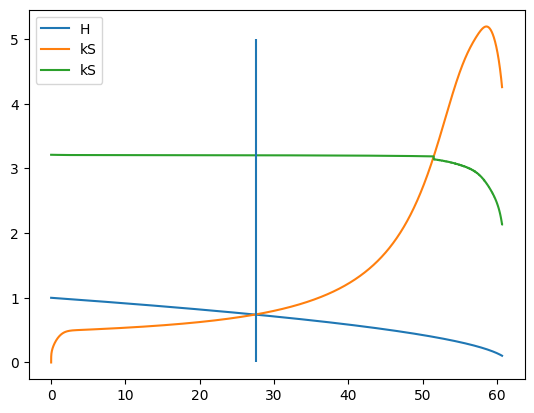

In [57]:
plt.plot(NG, HG, label="H")
plt.plot(NG, kSG/aG, label="kS")
plt.plot(NG, khG/aG, label="kS")
plt.vlines(27.5, 0., 5.)
plt.legend(loc=0)
plt.show()

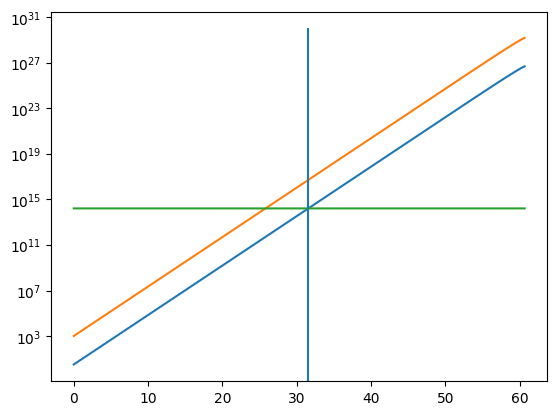

In [62]:
plt.plot(NG, khG)
plt.plot(NG, 10**(5/2)*khG)
plt.yscale("log")
plt.plot(NG, np.ones(NG.size)*CubicSpline(NG, khG)(35.)*10**(-3/2))
plt.vlines(31.5, 0., 1e30)
plt.show()

In [63]:
file = "Out/GEF_Beta25.0_SE" + name + ".dat"
input_df = pd.read_table(file, sep=",")
#data = input_df.values
omega = 3.814203717684728e-05
data = dict(zip(input_df.columns[1:],input_df.values[1:,1:].T))
NR = data["N"]
tR = data["t"]
aR = data["a"]
khR = data["kh"]
dphidtR = data["dphi"]
af = CubicSpline(tR, aR)
dphidtf = CubicSpline(tR, dphidtR)
khf = CubicSpline(tR, khR)
sigmaER = data["sigmaE"]
sigmaBR = data["sigmaB"]

sigmaEf = CubicSpline(tR, sigmaER)
sigmaBf = CubicSpline(tR, sigmaBR)
kSR = data["kS"]

deltaf = lambda t: 1.

kSf = CubicSpline(tR[1:], kSR[1:])

In [64]:
tini = CubicSpline(tR, NR)(31.5)
steps = 500
tfin = CubicSpline(tR, NR)(35.)
print(tini, tfin)

27.421029154892437 29.96467938625325


In [66]:
Ap, dAp, Am, dAm, ks, ts = ModeByModeKDep(1., tini, tfin, khf, dphidtf, beta/Mpl, af, kFerm=kSf,
                                                        steps=steps, sigmaE=sigmaEf, sigmaB=sigmaBf, delta=deltaf)

skip
Elapsed time: 623.2138 seconds


In [67]:
khs = khf(ts)
a = af(ts)
Ns = np.log(a)

/tmp/ipykernel_206071/613017235.py:3: RuntimeWarning: invalid value encountered in log
  Ns = np.log(a)


In [68]:

lenE = []
lenB = []
lenG = []
#print(Ap[60,:])
#print(ts.size)
for i in range(len(ts)):
    Etmp, Btmp, Gtmp = EstimateCorrLen(Ap[:,i], Am[:,i], dAp[:,i], dAm[:,i], a[i], ks, khs[i])
    lenE.append(Etmp)
    lenB.append(Btmp)
    lenG.append(Gtmp)
    
lenE = np.array(lenE)
lenB = np.array(lenB)
lenG = np.array(lenG)

In [69]:
lenE2 = []
lenB2 = []
lenG2 = []
#print(Ap[60,:])
#print(ts.size)
for i in range(len(ts)):
    Etmp, Btmp, Gtmp = EstimateCorrLenInt(Ap[:,i], Am[:,i], dAp[:,i], dAm[:,i], af(ts[i]), ks, khs[i])
    lenE2.append(Etmp)
    lenB2.append(Btmp)
    lenG2.append(Gtmp)
    
lenE2 = np.array(lenE2)
lenB2 = np.array(lenB2)
lenG2 = np.array(lenG2)

/tmp/ipykernel_206071/2017646891.py:1: RuntimeWarning: divide by zero encountered in divide
  plt.plot(Ns, CubicSpline(tG,EG/aG)(ts)/(lenE), label=r"$\lambda_E^{-1}$")
/tmp/ipykernel_206071/2017646891.py:2: RuntimeWarning: divide by zero encountered in divide
  plt.plot(Ns, CubicSpline(tG,BG/aG)(ts)/(lenB), label=r"$\lambda_B^{-1}$")
/tmp/ipykernel_206071/2017646891.py:3: RuntimeWarning: divide by zero encountered in divide
  plt.plot(Ns, CubicSpline(tG,GG/aG)(ts)/(lenG), label=r"$\lambda_G^{-1}$")


(0.001, 10000000000.0)

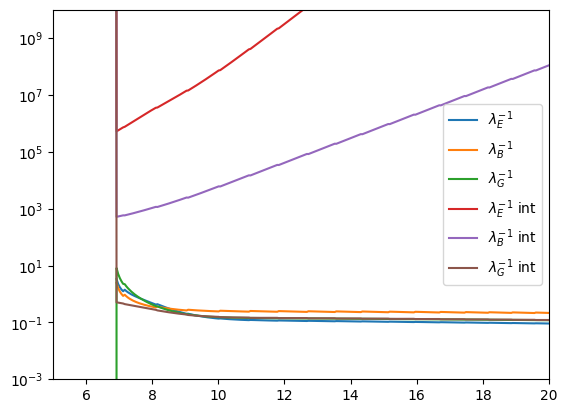

In [70]:
plt.plot(Ns, CubicSpline(tG,EG/aG)(ts)/(lenE), label=r"$\lambda_E^{-1}$")
plt.plot(Ns, CubicSpline(tG,BG/aG)(ts)/(lenB), label=r"$\lambda_B^{-1}$")
plt.plot(Ns, CubicSpline(tG,GG/aG)(ts)/(lenG), label=r"$\lambda_G^{-1}$")
plt.plot(Ns, 1/(lenE2)*CubicSpline(tG,aG)(ts), label=r"$\lambda_E^{-1}$ int")
plt.plot(Ns, 1/(lenB2), label=r"$\lambda_B^{-1}$ int")
plt.plot(Ns, CubicSpline(tG,1/aG)(ts)/(lenG2), label=r"$\lambda_G^{-1}$ int")
plt.xlim(5, 20)
plt.yscale("log")
plt.legend(loc=0)
plt.ylim(1e-3, 1e10)

/tmp/ipykernel_206071/3822697752.py:4: RuntimeWarning: divide by zero encountered in divide
  plt.plot(Ns, CubicSpline(tG,EG/aG)(ts)/(lenE), label=r"$\lambda_E^{-1}$")


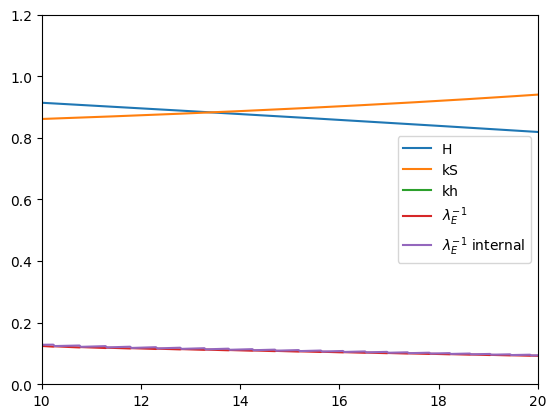

In [46]:
plt.plot(NG, HG, label="H")
plt.plot(NG, kSG/aG, label="kS")
plt.plot(NG, khG/aG, label="kh")
plt.plot(Ns, CubicSpline(tG,EG/aG)(ts)/(lenE), label=r"$\lambda_E^{-1}$")
plt.plot(Ns, CubicSpline(tG,1/aG)(ts)/(lenE2), label=r"$\lambda_E^{-1}$ internal")
#plt.vlines(27.5, 0., 5.)
plt.legend(loc=0)
plt.xlim(10, 20)
#plt.ylim(0, 1.2)
#plt.yscale("log")
plt.show()